In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Cleaning data

In [18]:
rusal_db = pd.read_csv('RUAL_170101_180410.csv', sep = ',')['<LAST>'].rename('RUSAL')
rusal_db.index = pd.to_datetime(rusal_db.index, format = '%Y%m%d')
nornick_db = pd.read_csv('GMKN_170101_180410.csv', sep = ',')['<LAST>'].rename('GMK')
nornick_db.index = pd.to_datetime(nornick_db.index, format = '%Y%m%d')

pair_db = pd.concat([rusal_db, nornick_db], axis = 1)
pair_db.head()

,RUSAL,GMK
2017-01-03,27.89,10350.0
2017-01-04,27.69,10286.0
2017-01-05,27.79,10250.0
2017-01-06,27.19,10060.0
2017-01-09,27.23,10131.0


Return series

In [19]:
pair_db_return = pair_db.pct_change().dropna()

Check cointegration

In [20]:
import statsmodels.tsa.stattools as ts 

coin_result = ts.coint(pair_db_return['RUSAL'], pair_db_return['GMK']) 
print('t-statistics: {:.3f}'.format(coin_result[0]), '\n'
      'P-value: {:.3f}'.format(coin_result[1]), '\n'
      'Critical value 1%: {:.3f}'.format(coin_result[2][0]), '\n'
      'Critical value 5%: {:.3f}'.format(coin_result[2][1]), '\n'
      'Critical value 10%: {:.3f}'.format(coin_result[2][2]))

t-statistics: -4.194 
P-value: 0.004 
Critical value 1%: -3.931 
Critical value 5%: -3.355 
Critical value 10%: -3.058


Build strategy

In [21]:
pair_db_return['diff'] = pair_db_return['RUSAL'] - pair_db_return['GMK']
pair_db_return['roll_10_ma'] = pd.rolling_mean(pair_db_return['diff'], 10)
pair_db_return['roll_90_ma'] = pd.rolling_mean(pair_db_return['diff'], 90)
pair_db_return['roll_90_std'] = pd.rolling_std(pair_db_return['diff'], 90)

In [22]:
pair_db_return.dropna(inplace= True)
pair_db_return.head()

,RUSAL,GMK,diff,roll_10_ma,roll_90_ma,roll_90_std
2017-05-16,-0.018258,-0.001172,-0.017086,-0.000304,0.002454,0.023807
2017-05-17,0.005007,-0.008099,0.013106,0.000026,0.002610,0.023830
2017-05-18,-0.005338,-0.000828,-0.004510,0.000746,0.002481,0.023837
2017-05-19,-0.007513,0.006040,-0.013553,0.000650,0.002365,0.023890
2017-05-22,-0.013338,-0.014126,0.000788,-0.000316,0.002435,0.023876


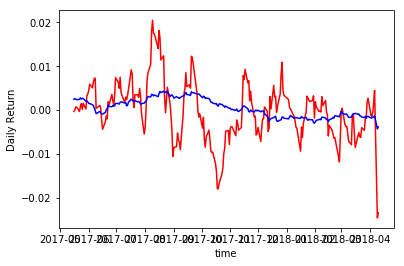

In [23]:
_ = plt.plot(pair_db_return['roll_10_ma'], c = 'r', label = 'rolling 10-day MA')
_ = plt.plot(pair_db_return['roll_90_ma'], c = 'b', label = 'rolling 90-day MA')
_ = plt.xlabel('time')
_ = plt.ylabel('Daily Return')
plt.show();

Z-score

In [24]:
pair_db_return['Z-score'] = (pair_db_return['roll_10_ma'] - pair_db_return['roll_90_ma'])/pair_db_return['roll_90_std']

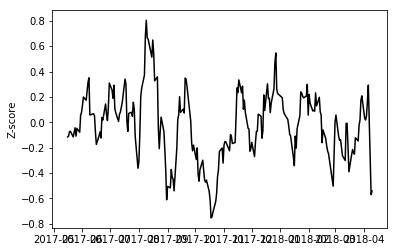

In [25]:
_ = plt.plot(pair_db_return['Z-score'], c = 'black')
_ = plt.ylabel('Z-score')
plt.show()

Buy - Sell Strategy

In [26]:
pair_db_return['strategy'] = 0
pair_db_return['strategy'][pair_db_return['Z-score']<-0.5] = -1
pair_db_return['strategy'][pair_db_return['Z-score']>0.5] = 1

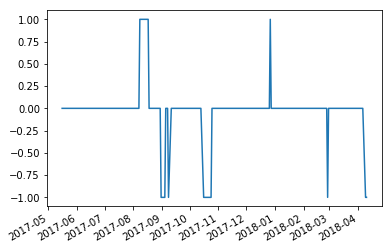

In [27]:
pair_db_return['strategy'].plot();

Estimate Return

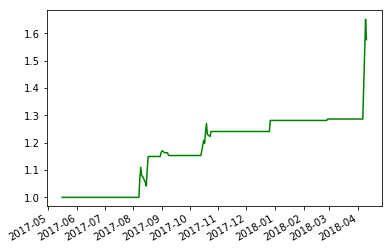

In [28]:
pair_db_return['dreturn'] = 1+ pair_db_return['strategy']*pair_db_return['diff']
pair_db_return['cumulative'] = pair_db_return['dreturn'].cumprod()
pair_db_return['cumulative'].plot(c = 'g');